In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from torch import nn
import numpy as np
import sys
import matplotlib.pyplot as plt
import math
import random
import sklearn.metrics as perf
import os
import cv2
from PIL import Image

# Link to dataset: https://susanqq.github.io/UTKFace/
# Relevant paper: Multi-task learning using uncertainty to weigh losses: https://arxiv.org/abs/1705.07115

In [2]:
### Load in the data

class FacesDataset(Dataset):
    def __init__(self, folder='UTKFace', transform=None, age_filter=None):
        self.data_list = []
        self.transform = transform
        self.folder = folder
        
        for filename in os.listdir(self.folder):
            components = filename.split('_')
            if len(components) == 4:
                age = int(components[0])
                gender = int(components[1])
                ethnicity = int(components[2])
                img = Image.open(f'{self.folder}/{filename}')
                img = self.transform(img)
                img = img.type(torch.FloatTensor)

                self.data_list.append([img, age, gender, ethnicity])
            

    def __len__(self):
        return len(self.data_list)


    def __getitem__(self, idx):
        return self.data_list[idx]

In [3]:
### Create class mapping from string class labels
folder = 'UTKFace'
    
#### Set up data transforms
def data_transform():
    return transforms.Compose([
        transforms.ToTensor(),
    ])

In [4]:
transform = data_transform()
dataset = FacesDataset(folder=folder, transform=transform)

In [5]:
### Get counts of each class by task in the dataset
ages = {}
genders = {}
ethnicities = {}

for img, age, gender, ethnicity in dataset:
    if age not in ages:
        ages[age] = 0
    else:
        ages[age] += 1
        
    if gender not in genders:
        genders[gender] = 0
    else:
        genders[gender] += 1
    
    if ethnicity not in ethnicities:
        ethnicities[ethnicity] = 0
    else:
        ethnicities[ethnicity] += 1

In [6]:
ages

{100: 10,
 101: 1,
 103: 0,
 105: 4,
 10: 155,
 110: 4,
 111: 0,
 115: 2,
 116: 3,
 11: 64,
 12: 129,
 13: 80,
 14: 156,
 15: 176,
 16: 246,
 17: 157,
 18: 261,
 19: 97,
 1: 1122,
 20: 283,
 21: 345,
 22: 394,
 23: 425,
 24: 858,
 25: 733,
 26: 2196,
 27: 614,
 28: 917,
 29: 569,
 2: 481,
 30: 723,
 31: 349,
 32: 663,
 33: 142,
 34: 408,
 35: 879,
 36: 482,
 37: 292,
 38: 324,
 39: 264,
 3: 288,
 40: 525,
 41: 131,
 42: 265,
 43: 156,
 44: 99,
 45: 439,
 46: 152,
 47: 169,
 48: 152,
 49: 147,
 4: 272,
 50: 380,
 51: 137,
 52: 231,
 53: 240,
 54: 352,
 55: 267,
 56: 235,
 57: 96,
 58: 270,
 59: 81,
 5: 195,
 60: 292,
 61: 158,
 62: 124,
 63: 102,
 64: 49,
 65: 258,
 66: 76,
 67: 93,
 68: 99,
 69: 55,
 6: 130,
 70: 146,
 71: 32,
 72: 97,
 73: 62,
 74: 31,
 75: 147,
 76: 57,
 77: 27,
 78: 68,
 79: 22,
 7: 138,
 80: 132,
 81: 21,
 82: 39,
 83: 17,
 84: 23,
 85: 154,
 86: 34,
 87: 9,
 88: 33,
 89: 32,
 8: 262,
 90: 81,
 91: 1,
 92: 12,
 93: 4,
 95: 8,
 96: 16,
 99: 8,
 9: 165}

In [7]:
genders

{0: 12390, 1: 11313}

In [8]:
ethnicities

{0: 10077, 2: 3433, 1: 4525, 3: 3974, 4: 1691}

In [9]:
### Set up train and val datasets and loaders
train_len = int(len(dataset)*0.8)
val_len = len(dataset) - train_len
train_dataset, val_dataset = random_split(dataset, [train_len, val_len], torch.Generator().manual_seed(8))

train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16, shuffle=False)

In [10]:
def get_metrics(gt_vec, pred_vec):
    accuracy = perf.accuracy_score(gt_vec, pred_vec)
    f1 = perf.f1_score(gt_vec, pred_vec, average='macro')
    
    return f1, accuracy

### Define new architecture

In [11]:
### Define model

class MTLClassifierPretrained(nn.Module):
    def __init__(self, num_channels=3, num_genders=2, num_ethnicities=5):
        super(MTLClassifierPretrained, self).__init__()
        
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        # Encoding #
        # Load a pre-trained encoder
        self.encoder = torchvision.models.resnet18(pretrained=True)
        #for name, parameter in self.encoder.named_parameters():
        #    parameter.requires_grad = False

        # Task 1: Age Regression
        self.class2_age = nn.Sequential(nn.Linear(in_features=1000, out_features=600),
                                        nn.ReLU(),
                                        nn.Dropout(p=0.1))
        self.class1_age = nn.Sequential(nn.Linear(in_features=600, out_features=300),
                                        nn.ReLU(),
                                        nn.Dropout(p=0.1))
        self.class0_age = nn.Linear(in_features=300, out_features=1)
        
        # Task 2: Gender Classification
        self.class2_gender = nn.Sequential(nn.Linear(in_features=1000, out_features=600),
                                        nn.ReLU(),
                                        nn.Dropout(p=0.1))
        self.class1_gender = nn.Sequential(nn.Linear(in_features=600, out_features=300),
                                        nn.ReLU(),
                                        nn.Dropout(p=0.1))
        self.class0_gender = nn.Linear(in_features=300, out_features=num_genders)
        
        
        # Task 3: Ethnicity Classification
        self.class2_ethnicity = nn.Sequential(nn.Linear(in_features=1000, out_features=600),
                                        nn.ReLU(),
                                        nn.Dropout(p=0.1))
        self.class1_ethnicity = nn.Sequential(nn.Linear(in_features=600, out_features=300),
                                        nn.ReLU(),
                                        nn.Dropout(p=0.1))
        self.class0_ethnicity = nn.Linear(in_features=300, out_features=num_ethnicities)
        
        
    def forward(self, X):
        # Encoding
        
        encoding = self.encoder(X)
        
        # Task 1: Age Regression
        age_output = self.class2_age(encoding)
        age_output = self.class1_age(age_output)
        age_output = self.class0_age(age_output)
        
        # Task 2: Gender Classification
        gender_output = self.class2_gender(encoding)
        gender_output = self.class1_gender(gender_output)
        gender_output = self.class0_gender(gender_output)
        
        # Task 3: Ethnicity Classification
        ethnicity_output = self.class2_ethnicity(encoding)
        ethnicity_output = self.class1_ethnicity(ethnicity_output)
        ethnicity_output = self.class0_ethnicity(ethnicity_output)
        
        return age_output, gender_output, ethnicity_output

In [12]:
model = MTLClassifierPretrained()
model = model.cuda()

criterion = nn.CrossEntropyLoss()
mse = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

### Fine-tune this model

In [13]:
num_epochs = 10
best_val_loss = float(math.inf)
age_coeff = 0.004
gender_coeff = 2
ethni_coeff = 1

for epoch in range(num_epochs + 1):
    avg_train_loss = 0
    tot_train_loss = 0
    tot_train_age_loss = 0
    tot_train_gender_loss = 0
    tot_train_ethni_loss = 0
    tot_train_samples = 0
    
    # Training Loop
    model.train()
    for i, (img, age, gender, ethnicity) in enumerate(train_loader):
        img = img.cuda()
        age = age.float().cuda()
        gender = gender.long().cuda()
        ethnicity = ethnicity.long().cuda()

        # Clear grad
        optimizer.zero_grad()

        # Get outputs
        age_output, gender_output, ethnicity_output = model(img)
        age_output = age_output.squeeze(1)
        gender_output = gender_output
        ethnicity_output = ethnicity_output

        # Calculate losses
        age_loss = mse(age_output, age)
        gender_loss = criterion(gender_output, gender)
        ethnicity_loss = criterion(ethnicity_output, ethnicity)
        multi_loss = age_coeff*age_loss + gender_coeff*gender_loss + ethni_coeff*ethnicity_loss
            
        tot_train_loss += multi_loss.item()
        tot_train_age_loss += age_coeff*age_loss.item()
        tot_train_gender_loss += gender_coeff*gender_loss.item()
        tot_train_ethni_loss += ethni_coeff*ethnicity_loss.item()
        tot_train_samples += img.shape[0]

        # Get grad
        multi_loss.backward()

        # Update model weights
        optimizer.step()
        
    avg_train_loss = tot_train_loss / tot_train_samples
    avg_train_age_loss = tot_train_age_loss / tot_train_samples
    avg_train_gender_loss = tot_train_gender_loss / tot_train_samples
    avg_train_ethni_loss = tot_train_ethni_loss / tot_train_samples


    avg_val_loss = 0
    tot_val_loss = 0
    tot_val_age_loss = 0
    tot_val_gender_loss = 0
    tot_val_ethni_loss = 0
    tot_val_samples = 0
    
    # Iterate through the val dataset
    model.eval()
    for i, (img, age, gender, ethnicity) in enumerate(val_loader):
        img = img.cuda()
        age = age.float().cuda()
        gender = gender.long().cuda()
        ethnicity = ethnicity.long().cuda()

        # Clear grad
        optimizer.zero_grad()

        # Get outputs
        age_output, gender_output, ethnicity_output = model(img)
        age_output = age_output.squeeze(1)
        gender_output = gender_output
        ethnicity_output = ethnicity_output

        # Calculate losses
        age_loss = mse(age_output, age)
        gender_loss = criterion(gender_output, gender)
        ethnicity_loss = criterion(ethnicity_output, ethnicity)
        multi_loss = age_coeff*age_loss + gender_coeff*gender_loss + ethni_coeff*ethnicity_loss
        
        tot_val_loss += multi_loss.item()
        tot_val_age_loss += age_coeff*age_loss.item()
        tot_val_gender_loss += gender_coeff*gender_loss.item()
        tot_val_ethni_loss += ethni_coeff*ethnicity_loss.item()
        tot_val_samples += img.shape[0]
        
    avg_val_loss = tot_val_loss / tot_val_samples
    avg_val_age_loss = tot_val_age_loss / tot_val_samples
    avg_val_gender_loss = tot_val_gender_loss / tot_val_samples
    avg_val_ethni_loss = tot_val_ethni_loss / tot_val_samples

    if (avg_val_loss < best_val_loss):
        torch.save(model.state_dict(),"mtl_face_model_pretrained.pt")
        print (f'Epoch {epoch}, val loss: {best_val_loss:.5f} -> {avg_val_loss:.5f}, train loss: {avg_train_loss:.5f}')
        print (f'Epoch {epoch}, age val loss: {avg_val_age_loss:.5f}, gender val loss: {avg_val_gender_loss:.5f}, ethnicity val loss: {avg_val_ethni_loss:.5f}')
        print()
        best_val_loss = avg_val_loss
    else:
        print (f'Epoch {epoch}, val loss: {avg_val_loss:.5f}, train loss: {avg_train_loss:.5f}')
        print (f'Epoch {epoch}, age val loss: {avg_val_age_loss:.5f}, gender val loss: {avg_val_gender_loss:.5f}, ethnicity val loss: {avg_val_ethni_loss:.5f}')
        print()

Epoch 0, val loss: inf -> 0.12672, train loss: 0.15541
Epoch 0, age val loss: 0.02801, gender val loss: 0.04493, ethnicity val loss: 0.05378

Epoch 1, val loss: 0.12672 -> 0.10295, train loss: 0.11183
Epoch 1, age val loss: 0.02150, gender val loss: 0.03870, ethnicity val loss: 0.04275

Epoch 2, val loss: 0.10295 -> 0.08854, train loss: 0.09614
Epoch 2, age val loss: 0.02062, gender val loss: 0.03009, ethnicity val loss: 0.03782

Epoch 3, val loss: 0.08879, train loss: 0.08600
Epoch 3, age val loss: 0.02102, gender val loss: 0.02623, ethnicity val loss: 0.04153

Epoch 4, val loss: 0.08854 -> 0.08024, train loss: 0.07765
Epoch 4, age val loss: 0.01952, gender val loss: 0.02504, ethnicity val loss: 0.03568

Epoch 5, val loss: 0.08681, train loss: 0.07055
Epoch 5, age val loss: 0.01708, gender val loss: 0.03170, ethnicity val loss: 0.03803

Epoch 6, val loss: 0.08467, train loss: 0.06096
Epoch 6, age val loss: 0.01791, gender val loss: 0.02906, ethnicity val loss: 0.03769

Epoch 7, val lo

### Test predictions

In [14]:
model = MTLClassifierPretrained()
model.load_state_dict(torch.load('mtl_face_model_pretrained.pt'))
model = model.cuda()
model.eval()

### Get model performance
age_predictions = []
age_gt = []
gender_predictions = []
gender_gt = []
ethnicity_predictions = []
ethnicity_gt = []

with torch.no_grad():
    for i, (img, age, gender, ethnicity) in enumerate(val_loader):
        img = img.cuda()
        age = age.float().cuda()
        gender = gender.long().cuda()
        ethnicity = ethnicity.long().cuda()

        # Get outputs
        age_output, gender_output, ethnicity_output = model(img)
        age_output = age_output.squeeze(1)
        gender_output = gender_output
        ethnicity_output = ethnicity_output

        # Get predictions
        age_pred = age_output.cpu()
        gender_pred = torch.argmax(gender_output, axis=1).cpu()
        ethnicity_pred = torch.argmax(ethnicity_output, axis=1).cpu()
        
        # Append to lists
        age_predictions.extend(list(age_pred))
        age_gt.extend(list(age.cpu()))
        gender_predictions.extend(list(gender_pred))
        gender_gt.extend(list(gender.cpu()))
        ethnicity_predictions.extend(list(ethnicity_pred))
        ethnicity_gt.extend(list(ethnicity.cpu()))

f1_gender, accuracy_gender = get_metrics(gender_gt, gender_predictions)
f1_ethni, accuracy_ethni = get_metrics(ethnicity_gt, ethnicity_predictions)

print(f'gender f1: {f1_gender:.3f}, acc: {accuracy_gender:.3f}')
print(f'ethnicity f1: {f1_ethni:.3f}, acc: {accuracy_ethni:.3f}')

gender f1: 0.928, acc: 0.928
ethnicity f1: 0.710, acc: 0.826


### Show example predictions

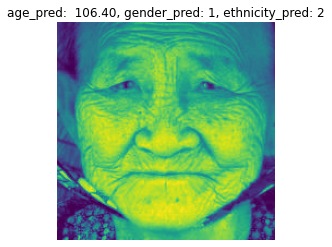

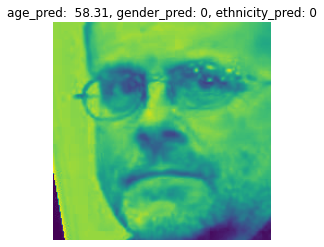

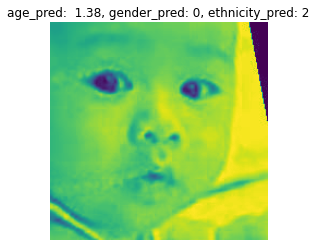

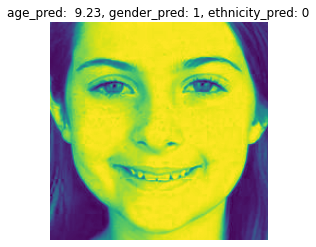

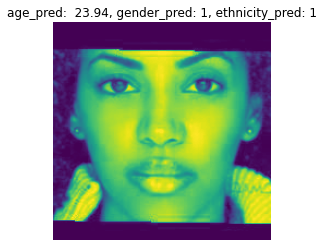

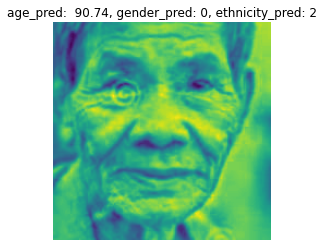

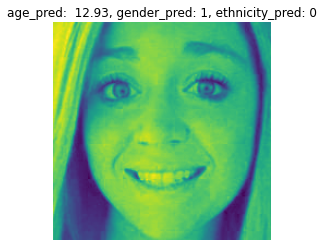

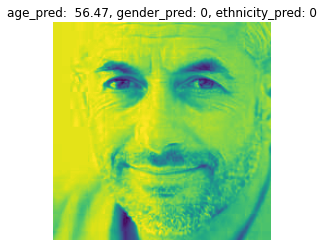

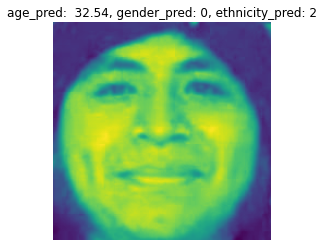

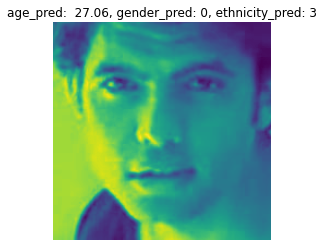

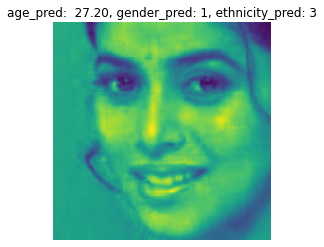

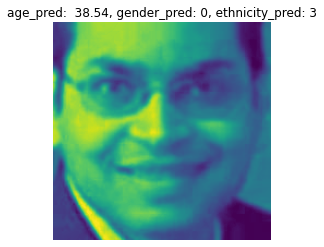

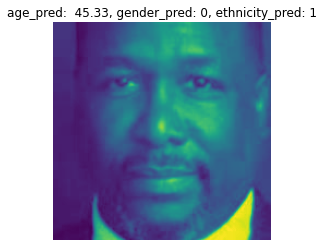

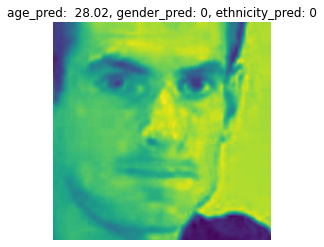

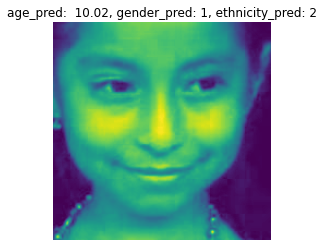

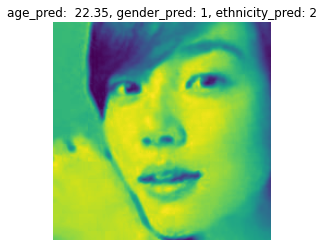

In [17]:
with torch.no_grad():
    for i, (img, age, gender, ethnicity) in enumerate(train_loader):
        img = img.cuda()
        age = age.float().cuda()
        gender = gender.long().cuda()
        ethnicity = ethnicity.long().cuda()

        # Get outputs
        age_output, gender_output, ethnicity_output = model(img)
        age_output = age_output.squeeze(1)
        gender_output = gender_output
        ethnicity_output = ethnicity_output

        # Get predictions
        age_pred = age_output
        gender_pred = torch.argmax(gender_output, axis=1)
        ethnicity_pred = torch.argmax(ethnicity_output, axis=1)
        break

for i in range(len(img)):
    plt.imshow(img[i][0].cpu())
    plt.axis('off')
    plt.title(f'age_pred: {age_pred[i].cpu(): .2f}, gender_pred: {gender_pred[i].cpu()}, ethnicity_pred: {ethnicity_pred[i].cpu()}')
    plt.show()

In [ ]:
### Try vgg face as the encoder: https://github.com/chi0tzp/PyVGGFace
### https://www.kaggle.com/shubhendumishra/recognizing-faces-in-the-wild-vggface-pytorch